# Data preprocessing and trajectory analysis

In [1]:
library(data.table) #fread
library(dplyr)
library(geosphere) # Calculate vehicle distance
library(lubridate)# Date column extraction
library(robfilter)# Smooth the data
library(ggplot2) # Plot
library(gridExtra) # Combine different plots
library(ggmap) # plot points on the map

Warning message:
"package 'data.table' was built under R version 3.6.3"
Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'geosphere' was built under R version 3.6.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from 'package:base':

    date


Warning message:
"package 'robfilter' was built under R version 3.6.3"
Loading required package: robustbase

Warning message:
"package 'robustbase' was built under R version 3.6.3"
Loading required package: MASS

Wa

In [28]:
library(scales)

Warning message:
"package 'scales' was built under R version 3.6.3"


In [2]:
# adjust the R limit
memory.limit(size=249200)

[1] 249200

## Input location data

In [2]:
# Read data from folder
# Suggestion: Just do one year at one time. One year's table has 94363502 rows(green)
YEARLIST = c('19')
MONTHlIST = c("04") #FOR FULL TABLE
DISTANCE_FILEPATH = "../../data/raw/vehicle-location/"

In [3]:
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
get_light_rail_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dg = add_dd_mm_yy_cols(dg)
    return(dg)
}
get_heavy_rail_trajectories = function(year, month){
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dh = add_dd_mm_yy_cols(dh)
    return(dh)
}

In [4]:
df_lightrail = get_light_rail_trajectories(YEARLIST,MONTHlIST)
df_heavyrail = get_heavy_rail_trajectories(YEARLIST,MONTHlIST)

In [14]:
light_subset = function(dayid,id){
    # Subset the table by all unique indexes
    day_trainid_subset = df_lightrail[day == dayid, .SD, keyby = .(trainid, vehicleid, routeid) ]
    unique_train_vehicle_route_car_tuple = unique(
    day_trainid_subset[, .(trainid, vehicleid, routeid, car1,car2,car3) ]
    )
    print(unique_train_vehicle_route_car_tuple)
    index = id
    # Select all conditions whi
    trajectory = day_trainid_subset[
    trainid == unique_train_vehicle_route_car_tuple[index, 1][[1]] & 
    vehicleid == unique_train_vehicle_route_car_tuple[index, 2][[1]] &
    routeid == unique_train_vehicle_route_car_tuple[index, 3][[1]],][order(trxtime)]
    clean_trajectory = trajectory[, .SD[1], by = trxtime]
    # transfer trxtime to timestamp
    options(tz = "America/New_York")
    clean_trajectory$time = as.POSIXct(clean_trajectory$trxtime,tz = getOption("tz"))
    return(clean_trajectory)
}

In [136]:
clean_trajectory = light_subset(1,2)

      trainid vehicleid routeid car1 car2 car3
   1:   10001      3699       0 3699   NA   NA
   2:   10001      3699     850 3699   NA   NA
   3:   10001      3699     850 3699 3856   NA
   4:   10001      3699     880 3699 3856   NA
   5:   10002      <NA>      NA   NA   NA   NA
  ---                                         
1204:   10473      3826     880 3826   NA   NA
1205:   10473      3826     880 3826 3644   NA
1206:   10474      3828       0 3828   NA   NA
1207:   10474      3828     880 3828   NA   NA
1208:   10474      3828     880 3828 3626   NA


In [128]:
run = function(clean_trajectory){
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    clean_trajectory  = compute_speed_acceleration(clean_trajectory)
    #train_plot(clean_trajectory)
    }

In [137]:
clean_trajectory = run(clean_trajectory)

In [138]:
clean_trajectory

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,...,inserted,day,month,year,time,interval_seconds,dist_meters,speed_mps,speed_kph,accel_mps2
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,...,<chr>,<int>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-04-01 06:35:54,10001,3699,850,17645,4,42.33666,-71.25081,1,0,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:35:54,NA,NA,NA,NA,NA
2019-04-01 06:36:00,10001,3699,850,17656,4,42.33633,-71.25019,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:00,6,62.70724,10.451207,37.624345,NA
2019-04-01 06:36:06,10001,3699,850,17675,4,42.33567,-71.24901,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:06,6,121.29373,20.215621,72.776237,1.6274024
2019-04-01 06:36:12,10001,3699,850,17793,4,42.33535,-71.24840,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:12,6,61.86077,10.310128,37.116461,-1.6509156
2019-04-01 06:36:13,10001,3699,850,17798,4,42.33506,-71.24777,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:13,1,60.99345,60.993453,219.576431,50.6833250
2019-04-01 06:36:18,10001,3699,850,17818,4,42.33475,-71.24716,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:18,5,61.18063,12.236127,44.050056,-9.7514653
2019-04-01 06:36:24,10001,3699,850,17842,4,42.33443,-71.24654,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:24,6,62.58200,10.430333,37.549198,-0.3009656
2019-04-01 06:36:25,10001,3699,850,17846,4,42.33411,-71.24592,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:25,1,61.64781,61.647806,221.932101,51.2174730
2019-04-01 06:36:36,10001,3699,850,17948,4,42.33382,-71.24534,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:36,11,57.18007,5.198188,18.713476,-5.1317835


In [42]:
heavy_subset = function(day,index){
   # Subset the table by all unique indexes
    day_trainid_subset = df_heavyrail[day == day, .SD, 
                                      keyby = .(trainid, vehicleid,lineid,tripid,heavyrailbranchid) ]
    unique_train_vehicle_route_car_tuple = unique(
    day_trainid_subset[, .(trainid,vehicleid,lineid,tripid,heavyrailbranchid) ]
    )
    #print(dim(unique_train_vehicle_route_car_tuple)[1])
    print(unique_train_vehicle_route_car_tuple)
    index = index
    trajectory = day_trainid_subset[
    trainid == unique_train_vehicle_route_car_tuple[index, 1][[1]] & 
    vehicleid == unique_train_vehicle_route_car_tuple[index, 2][[1]] &
    lineid == unique_train_vehicle_route_car_tuple[index, 3] &    
    tripid == unique_train_vehicle_route_car_tuple[index, 4] & 
    heavyrailbranchid == unique_train_vehicle_route_car_tuple[index, 5][[1]],][order(trxtime)]
    clean_trajectory = trajectory[, .SD[1], by = trxtime] 
    return(clean_trajectory)
}

# Basic summary

In [41]:
heavyrail_summary_table = function(df){
    # Calculate the number of different trainids, routes,vehicles for each line
    d_summary = df[,.(num_trainid = length(unique(df$trainid,na.rm =TRUE)),
                      num_routeid = length(unique(df$tripid,na.rm =TRUE)),
                      num_vehicleid = length(unique(df$vehicleid,na.rm =TRUE)),
                      num_branch = length(unique(df$heavyrailbranchid,na.rm =TRUE)),
                      num_trip = length(unique(df$tripid,na.rm =TRUE)))
                      #by = lineid
                   ] 
    return(d_summary)
}

In [42]:
heavyrail_summary_table(df_heavyrail)

num_trainid,num_routeid,num_vehicleid,num_branch,num_trip
<int>,<int>,<int>,<int>,<int>
1559,33966,2119,3,33966


# Function used for trajectory investigation

In [70]:
# Plot the map
light_location = function(df_lightrail_test){
    # get the map
    ma <- get_stamenmap(bbox = c(left = min(df_lightrail_test$lon), bottom = min(df_lightrail_test$lat), 
                                  right = max(df_lightrail_test$lon), top = max(df_lightrail_test$lat)), 
                         zoom = 14)
   # plotting the map with some points on it
   options(repr.plot.width = 20, repr.plot.height = 10)
   ggmap(ma) +
   geom_point(data = df_lightrail_test, aes(x = lon, y = lat, color = time, alpha = 0.7), size = 4, shape = 16) +
    geom_text(data = df_lightrail_test, aes(label=ifelse(speed_kph > 80,round(speed_kph,0),'')),hjust=0,vjust=0) +
#    scale_colour_gradient(
#    low = "#132B43",
#    high = "#56B1F7",
#    space = "Lab",
#    na.value = "grey50",
#    guide = "colourbar",
#    aesthetics = "colour") + 
   guides(fill=FALSE, alpha=FALSE, size=FALSE)
}

In [20]:
compute_time_interval <- function(d) {
    d$interval_seconds = NA
    n <- nrow(d)
    if (n >= 2) {
        # Compute time interval
        d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        }
    return(d)
}

In [18]:
compute_distance <- function(d) {
    d$dist_meters = NA
     n <- nrow(d)
    if (n >= 2) {
        # Compute interval distance using Haversine function
        d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
        }
    return(d)
}

In [17]:
compute_speed_acceleration <- function(d) {
    d$speed_mps = NA
    d$speed_kph = NA
    d$accel_mps2 = NA
    n <- nrow(d)
    if (n >= 2) {
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        }
    return(d)
}  

In [144]:
head(clean_trajectory)

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,...,inserted,day,month,year,time,interval_seconds,dist_meters,speed_mps,speed_kph,accel_mps2
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,...,<chr>,<int>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-04-01 06:35:54,10001,3699,850,17645,4,42.33666,-71.25081,1,0,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:35:54,NA,NA,NA,NA,NA
2019-04-01 06:36:00,10001,3699,850,17656,4,42.33633,-71.25019,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:00,6,62.70724,10.45121,37.62434,NA
2019-04-01 06:36:06,10001,3699,850,17675,4,42.33567,-71.24901,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:06,6,121.29373,20.21562,72.77624,1.627402
2019-04-01 06:36:12,10001,3699,850,17793,4,42.33535,-71.24840,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:12,6,61.86077,10.31013,37.11646,-1.650916
2019-04-01 06:36:13,10001,3699,850,17798,4,42.33506,-71.24777,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:13,1,60.99345,60.99345,219.57643,50.683325
2019-04-01 06:36:18,10001,3699,850,17818,4,42.33475,-71.24716,1,1,...,2019-04-19 15:20:20,1,4,2019,2019-04-01 06:36:18,5,61.18063,12.23613,44.05006,-9.751465


In [148]:
distance_filter = function(df){
   df = data.table(df)
   df = df[interval_seconds > 1]
   df = run(df)
    # Smooth the distance
   filter = robreg.filter(df$dist_meters, width=10,online=TRUE,method= "MED")
   plot(filter)
   df$dist_meters =  filter$level$MED
   df = compute_speed_acceleration(df)
  return(df) 
}

1 out of 179 time series values in df$dist_meters are missing. 


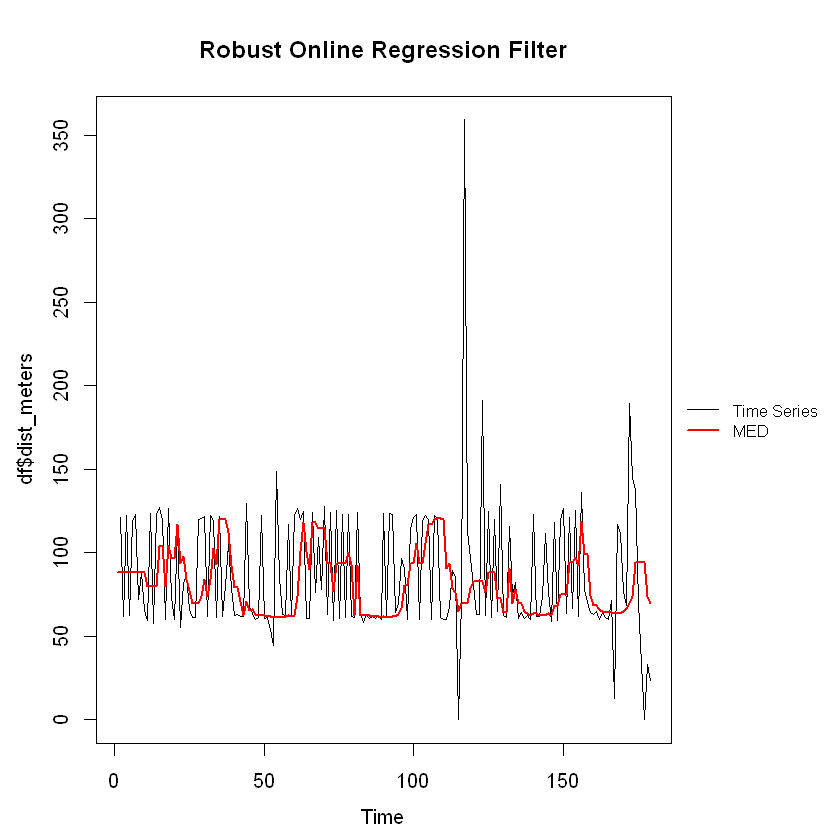

In [149]:
d_filter = distance_filter(clean_trajectory)

In [151]:
max(d_filter$dist_meters)

[1] 120.5394

In [147]:
dim(d_filter)
dim(clean_trajectory)

[1] 179  29

[1] 201  29

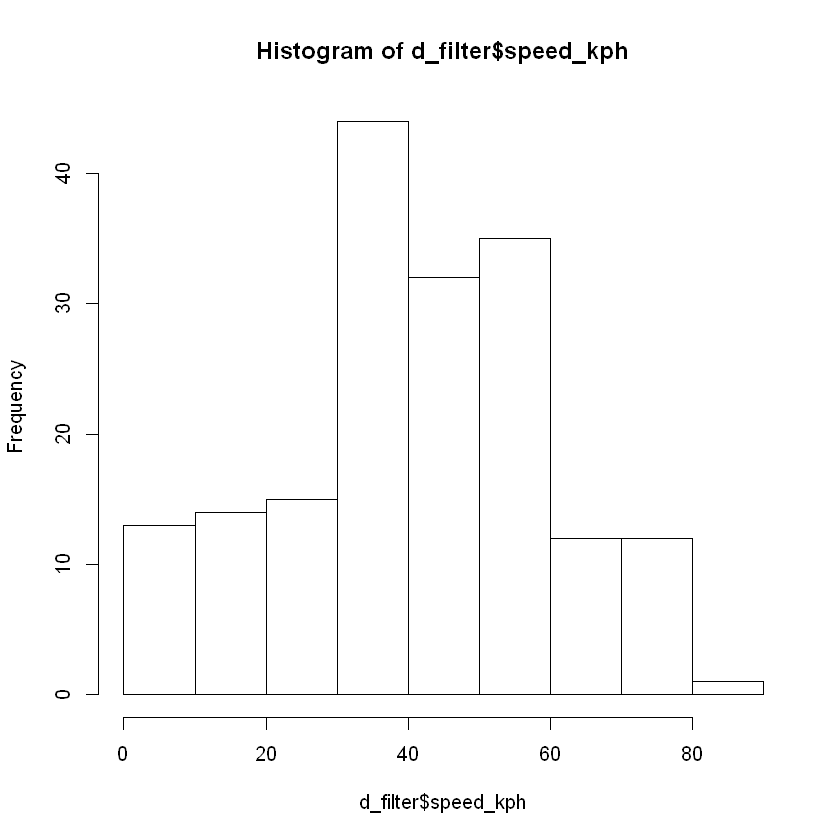

In [153]:
hist(d_filter$speed_kph)

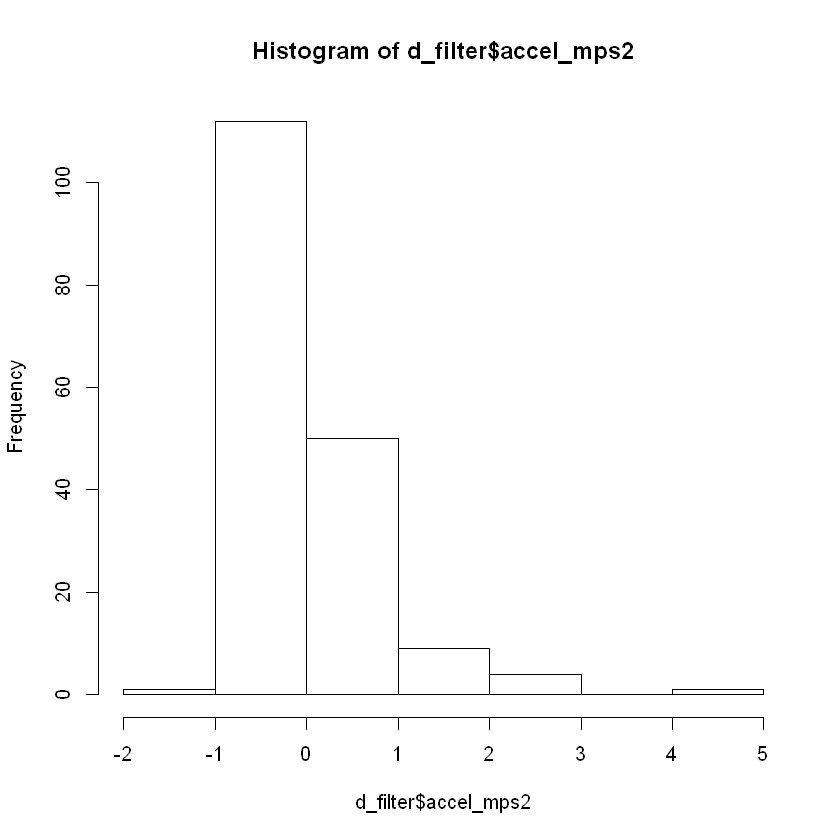

In [154]:
hist(d_filter$accel_mps2)

Warning message:
"Removed 5 rows containing missing values (geom_point)."


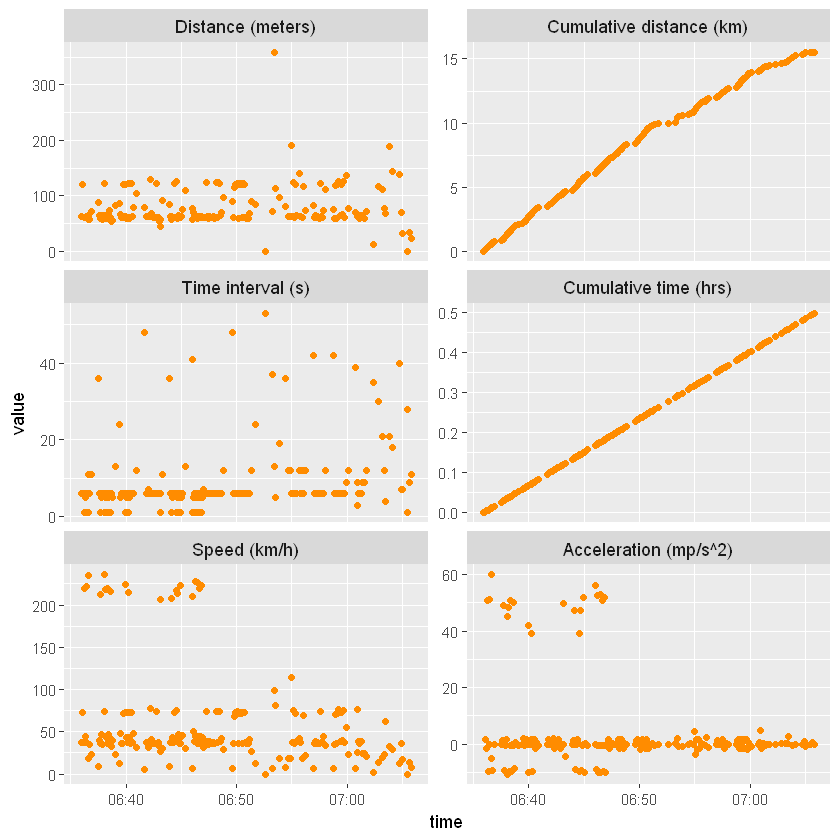

In [152]:
train_plot(d_filter)

Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."


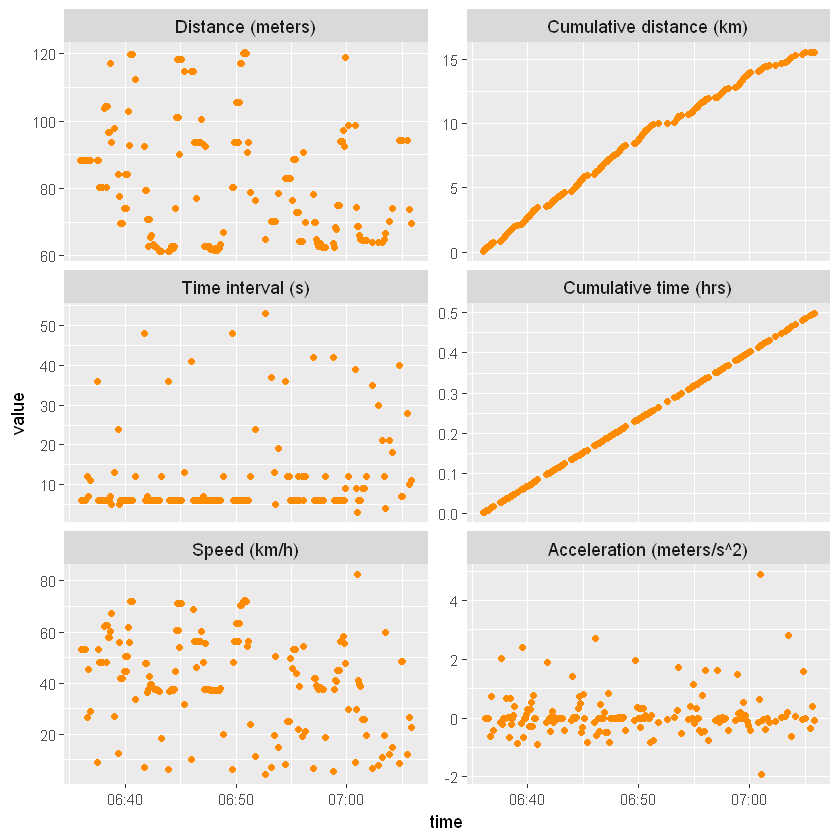

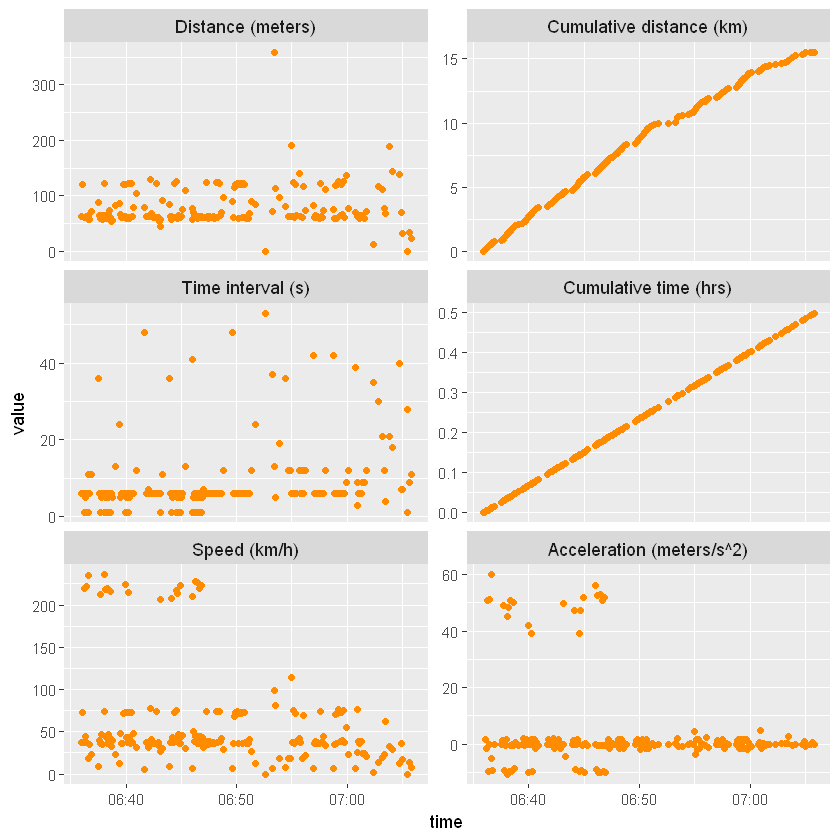

In [156]:
train_plot(d_filter)
train_plot(clean_trajectory)

In [103]:
compute_cumulative_time_distance = function(d){
    df = d
    # no rm.na argument in cumsum function,so we make distance and time with NA as 0
    df[is.na(df)] <- 0
    # Calculate the cumulative dist and time
    df = df %>%
    mutate(cumdist = cumsum(dist_meters)) %>%
    mutate(cumtime = cumsum(interval_seconds))
    d$cumdist_km = df$cumdist/1000
    d$cumtime_hrs = df$cumtime/3600
    return(d)
}

In [145]:
clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
d_filter = compute_cumulative_time_distance(d_filter)

In [107]:
clean_trajectory

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,...,time,interval_seconds,dist_meters,speed_mps,speed_kph,accel_mps2,cumdist,cumtime,cumdist_km,cumtime_hrs
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,...,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-04-01 06:35:54,10001,3699,850,17645,4,42.33666,-71.25081,1,0,...,2019-04-01 06:35:54,NA,NA,NA,NA,NA,0.00000,0,0.00000000,0.000000000
2019-04-01 06:36:00,10001,3699,850,17656,4,42.33633,-71.25019,1,1,...,2019-04-01 06:36:00,6,62.70724,10.451207,37.624345,NA,62.70724,6,0.06270724,0.001666667
2019-04-01 06:36:06,10001,3699,850,17675,4,42.33567,-71.24901,1,1,...,2019-04-01 06:36:06,6,121.29373,20.215621,72.776237,1.6274024,184.00097,12,0.18400097,0.003333333
2019-04-01 06:36:12,10001,3699,850,17793,4,42.33535,-71.24840,1,1,...,2019-04-01 06:36:12,6,61.86077,10.310128,37.116461,-1.6509156,245.86174,18,0.24586174,0.005000000
2019-04-01 06:36:13,10001,3699,850,17798,4,42.33506,-71.24777,1,1,...,2019-04-01 06:36:13,1,60.99345,60.993453,219.576431,50.6833250,306.85519,19,0.30685519,0.005277778
2019-04-01 06:36:18,10001,3699,850,17818,4,42.33475,-71.24716,1,1,...,2019-04-01 06:36:18,5,61.18063,12.236127,44.050056,-9.7514653,368.03582,24,0.36803582,0.006666667
2019-04-01 06:36:24,10001,3699,850,17842,4,42.33443,-71.24654,1,1,...,2019-04-01 06:36:24,6,62.58200,10.430333,37.549198,-0.3009656,430.61782,30,0.43061782,0.008333333
2019-04-01 06:36:25,10001,3699,850,17846,4,42.33411,-71.24592,1,1,...,2019-04-01 06:36:25,1,61.64781,61.647806,221.932101,51.2174730,492.26563,31,0.49226563,0.008611111
2019-04-01 06:36:36,10001,3699,850,17948,4,42.33382,-71.24534,1,1,...,2019-04-01 06:36:36,11,57.18007,5.198188,18.713476,-5.1317835,549.44569,42,0.54944569,0.011666667


Warning message in melt(clean_trajectory, id.vars = c("time", "month", "day"), measure.vars = c("dist_meters", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(clean_trajectory). In the next version, this warning will become an error."
Warning message:
"Removed 5 rows containing missing values (geom_point)."


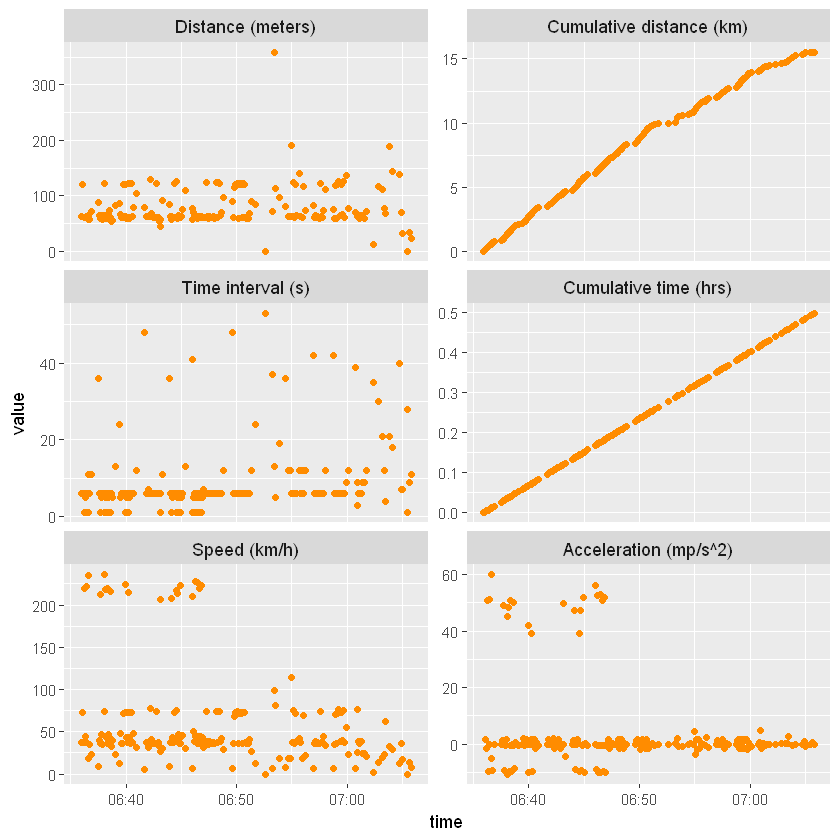

In [106]:
train_plot(clean_trajectory)

In [155]:
train_plot = function(df){
    clean_trajectory_melt = melt(df, id.vars = c("time","month","day") ,
                                 measure.vars = c("dist_meters","cumdist_km","interval_seconds","cumtime_hrs","speed_kph","accel_mps2"))
    # Name new labels for plot
    levels(clean_trajectory_melt$variable) = c("Distance (meters)","Cumulative distance (km)",
                                               "Time interval (s)","Cumulative time (hrs)","Speed (km/h)","Acceleration (meters/s^2)")
    # generate the facet plot
    ggplot(clean_trajectory_melt,aes(x = time,y = value)) + 
    geom_point(colour="darkorange") + 
    theme(strip.text = element_text(size = rel(1))) + 
    facet_wrap(~variable,ncol = 2 , scales = "free_y")
   # return( clean_trajectory_melt)
}

## Green line investigation

In [75]:
df_green_test = green_subset(850,10404,'3628',18,4,3628,3878)

In [77]:
# Computation
df_green_test_dis = compute_distance(df_green_test)
df_green_test_dis_speed_accel = compute_speed_acceleration(df_green_test_dis)

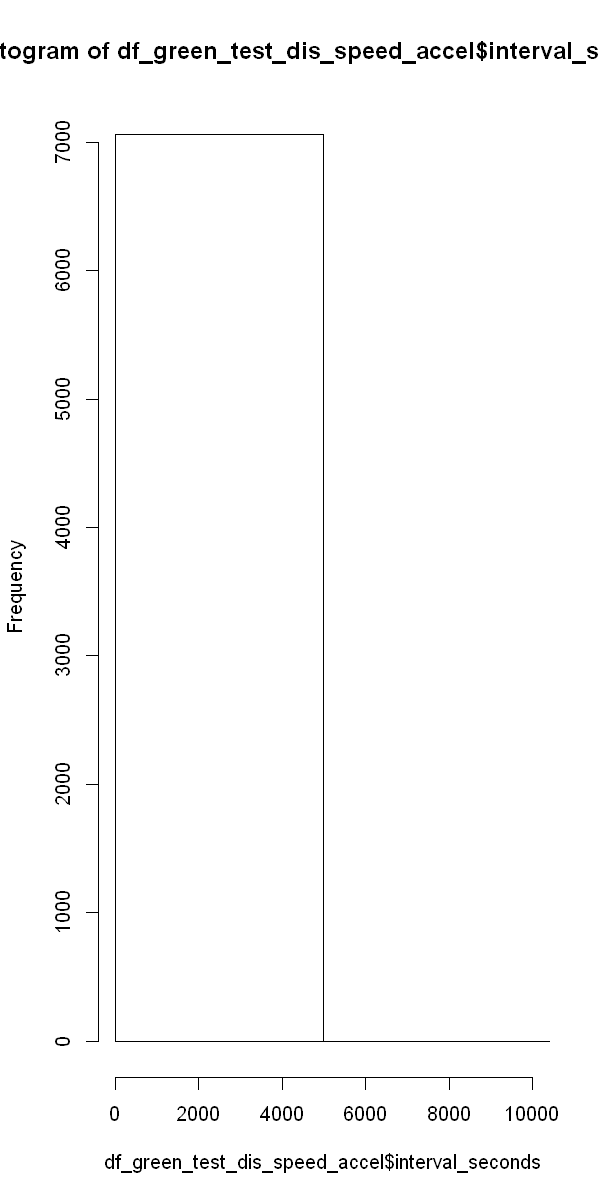

In [169]:
hist(df_green_test_dis_speed_accel$interval_seconds,xlim = c(0,10000))

## Data preprocessing

In [6]:
# Data preprocessing
preprocess_data = function(df){
    # Add time column to do analysis by random time scale
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    # check the na values ratio
    df_zero = df[df$lon == 0 | df$lat == 0,]
    df_zero_rate = nrow(df_zero)/nrow(df)
    print(df_zero_rate)
    # remove the rows with values of lat and lon are 0/NA
    df = df[!(is.na(df$lon)) | !(is.na(df$lat)),]
    df = df[df$lon != 0 | df$lat != 0,]
    df = df[order(df$trainid, df$trxtime),]
    df = distinct(df, trxtime, trainid, .keep_all = TRUE) # Remove the duplicated time record
    return(df)
}

In [7]:
df = preprocess_data(df)

[1] 0.0008356593


### Smoothing methods

In [ ]:
#df_test$dist_meters
filter = robreg.filter(clean_trajectory_melt$dist_meters, width=10,online=TRUE,method= "MED")

In [63]:
width = 10
right.width = 10

In [51]:
filter_wrm = wrm.filter(df_test_computed$dist_meters, width,weight.type = 1, del = floor(width/2), extrapolate = TRUE)

In [64]:
filter_scarm = scarm.filter(df_test_computed$dist_meters,right.width, min.left.width=right.width,
min.width=floor(right.width/3), max.width=200,sign.level=0.001, bound.noise.sd=0.01, rtr=TRUE,autocorrelations="automatic")

Warning message in scarm.filter(df_test_computed$dist_meters, right.width, min.left.width = right.width, :
"'min.width' must be an integer >=5; 'min.width' is set to 5.
"


In [70]:
filter_rmfilter = rm.filter(df_test_computed$dist_meters, width, minNonNAs = 5, online = FALSE, extrapolate = TRUE)

1 out of 255 time series values in y are missing. 


In [11]:
head(df_test_1415375776)

trxtime,trainid,lineid,lat,lon,day,month,year
<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
2019-04-30 20:23:51,1415375776,3,42.40392,-71.07747,30,4,2019
2019-04-30 20:43:41,1415375776,3,42.40669,-71.07697,30,4,2019
2019-04-30 20:45:26,1415375776,3,42.41500,-71.07683,30,4,2019
2019-04-30 20:46:00,1415375776,3,42.42273,-71.07593,30,4,2019
2019-04-30 20:46:37,1415375776,3,42.42668,-71.07428,30,4,2019
2019-04-30 20:47:04,1415375776,3,42.42861,-71.07350,30,4,2019


### test result

In [72]:
d1 = df_test_computed
d1$dist_meters = filter_rmfilter$level$RM
d1_speed_accel = compute_speed_acceleration(d1)

Warning message in strptime(xx, f, tz = tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in strptime(x, f, tz = tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(as.POSIXlt(x, tz, ...), tz, ...):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezon

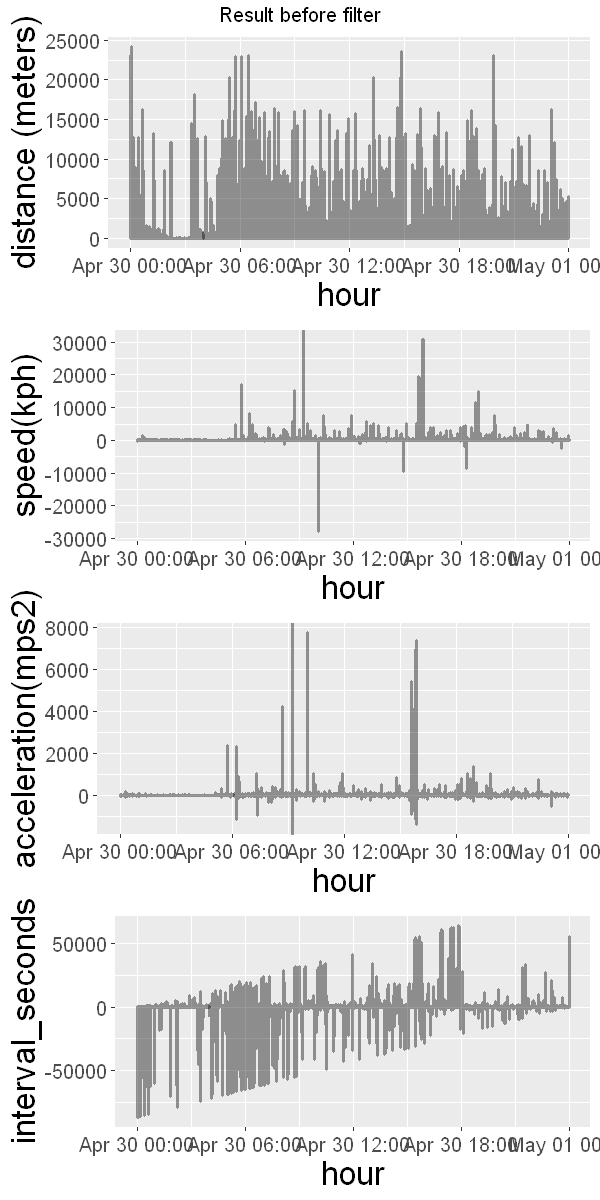

In [11]:
d_test = train_test()

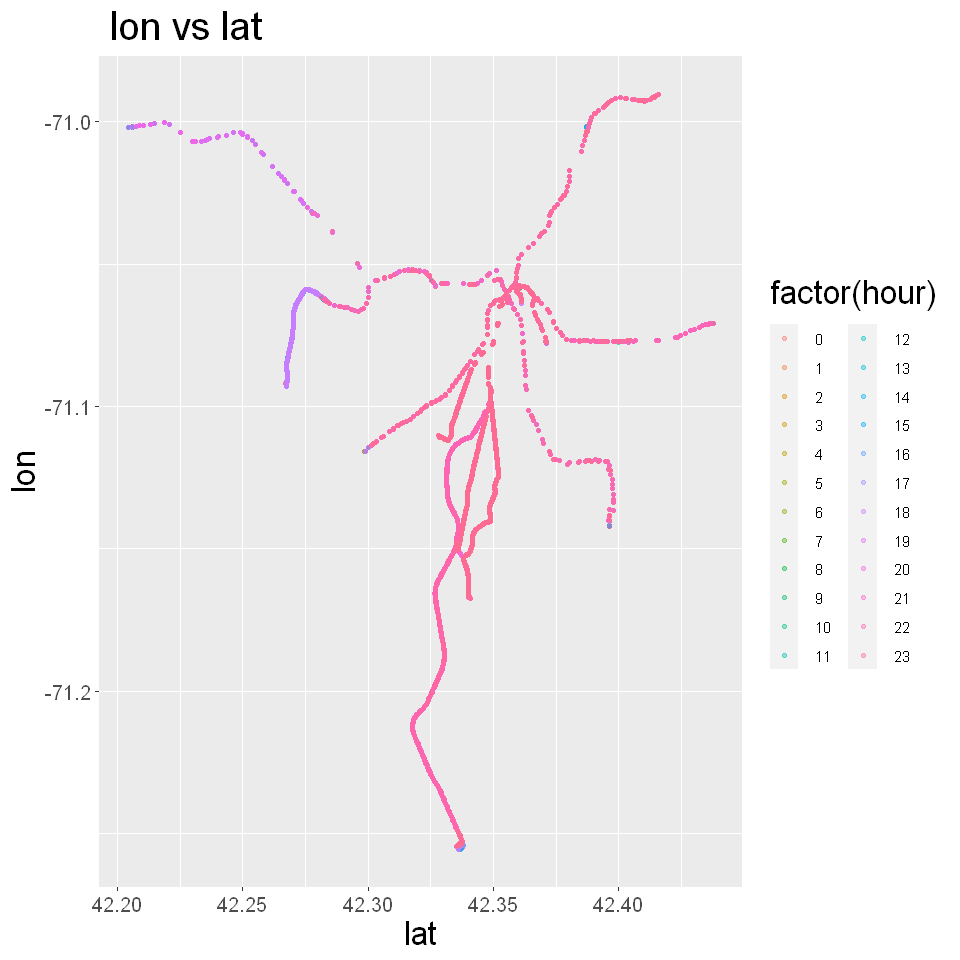

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(d_test) + 
    geom_point(aes(x = lat, y = lon,color = factor(hour)),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "lon", x = "lat")

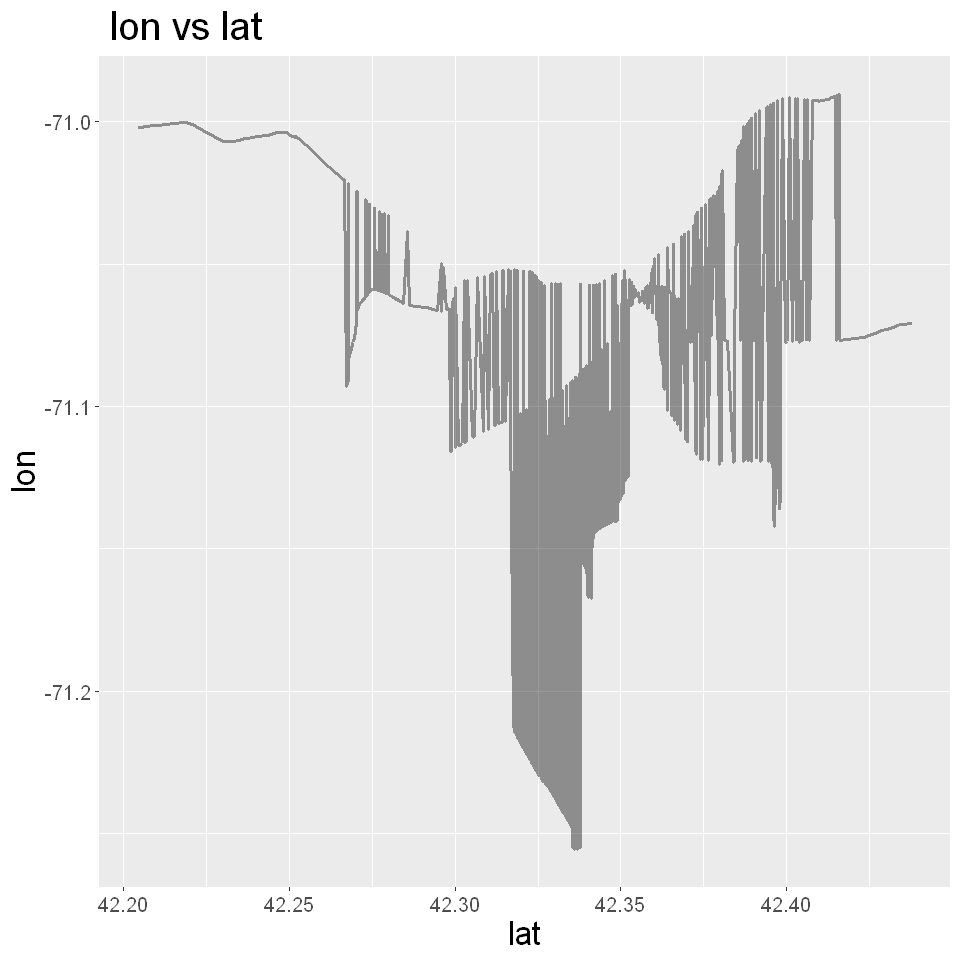

In [16]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(d_test) + 
    geom_line(aes(x = lat, y = lon),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "lon", x = "lat")

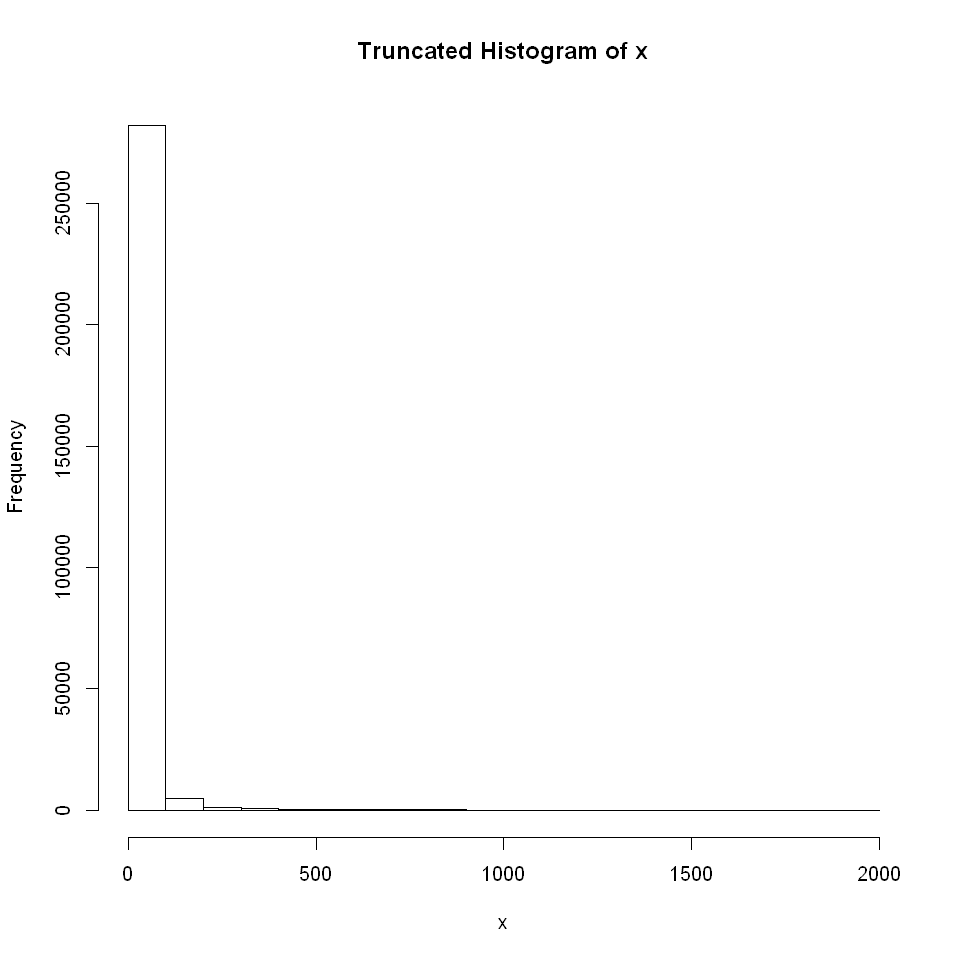

In [32]:
truncHist(d_test$interval_seconds,xmin = 0,xmax = 2000)

In [35]:
min(d_test$interval_seconds,na.rm = TRUE)

[1] -86388

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
War

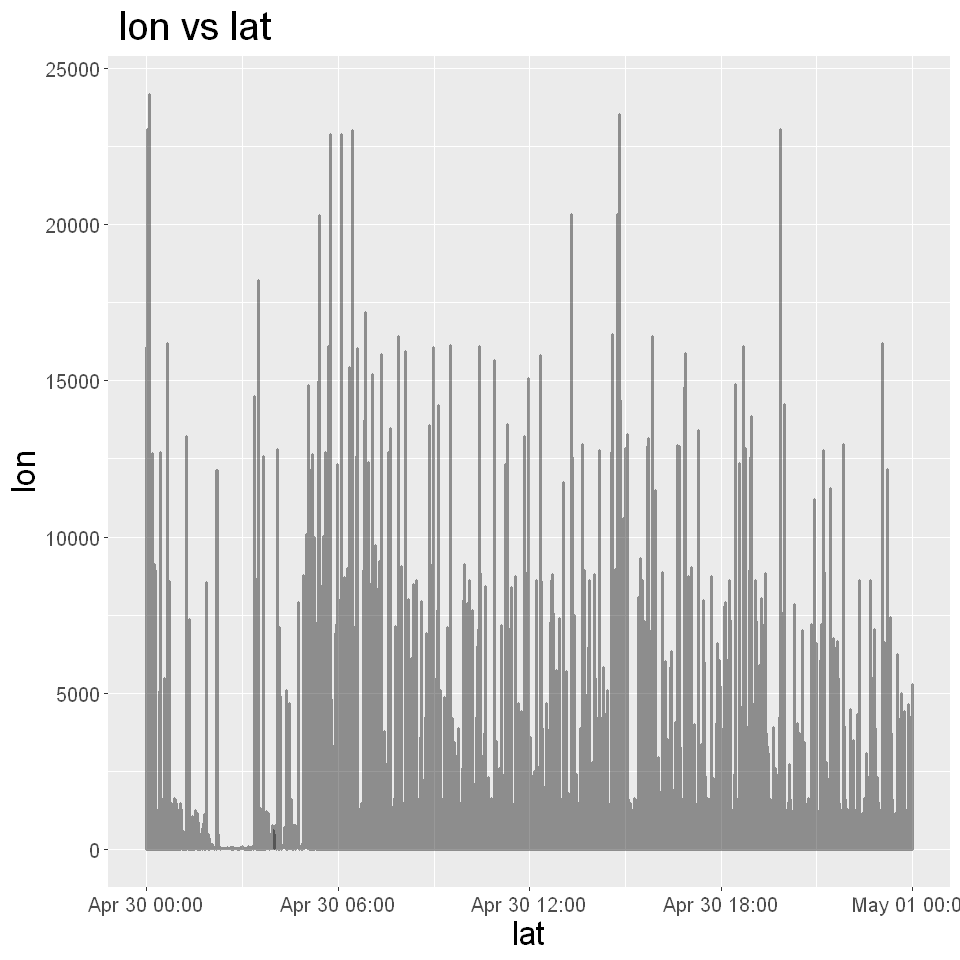

In [37]:
ggplot(d_test) + 
    geom_line(aes(x = time, y = dist_meters),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "lon", x = "lat")

In [43]:
d_test[d_test$interval_seconds < 0,c("interval_seconds")]

[1]     NA  -7932 -22448  -4215   -400  -6391 -11169 -78130  -8010  -1192
 [11] -66387  -9272 -83991  -6009 -58023 -68116 -67975   -257 -53762 -33447
 [21] -62078  -3147  -2104 -10452   -572  -5983  -1081 -41154 -66532  -4733
 [31] -59229 -56292   -526   -542 -47448 -19744  -2325 -86352 -49388 -39323
 [41]   -719 -73959 -28803   -780  -1827 -65616  -2350 -65451   -521 -62071
 [51] -77722 -35200 -64404 -85716  -1195   -465   -960 -45983 -11140 -21973
 [61] -60943 -64699 -46452 -21767   -669 -55474   -578 -86349 -17318 -63965
 [71] -64009    -82   -727   -397 -41830   -144 -61878 -18260 -18182 -12864
 [81]   -850   -923 -28392  -1026 -53134 -12889 -63272 -63172   -882 -63129
 [91] -10338 -59562  -1913   -401 -34070 -23777  -3137 -32565 -28166 -21319
[101] -61463 -61040 -53068 -32472 -61470   -442 -22130 -26296  -1535 -52780
[111]  -2951 -86178 -61001   -171 -42877  -4929 -60454 -13148 -59623 -59817
[121]   -910 -60030 -26439   -635 -28644  -8392  -4322 -45365 -43481  -1564
[131]  -1514   -358 -58499 -22075 -41384 -21552  -5689  -8911   -496  -1989
[141] -17834 -29394 -55079   -901    -18 -29611  -2994     -3 -56310 -26153
[151] -52439  -1076  -3433   -281 -31515 -54860 -31539    -41   -842  -2903
[161] -32878  -4024 -32290 -19682 -41027   -378 -83152 -86388  -1663  -2172
[171] -41187  -2000   -468   -698 -19574 -38083  -6893     -1 -38141  -2483
[181] -36736 -36680  -2908   -723 -13573 -37558 -42178 -48626  -4066   -870
[191] -34640 -32306  -2152  -2331 -22929  -5100 -42622 -31386  -1462  -2074
[201]   -320 -49609 -22062   -423 -34042 -30424  -1767  -1773   -185    -55
[211] -41157     -4  -1195  -1871  -1785    -86   -108 -28384 -85798  -8513
[221]  -1540  -2882  -1829  -1386   -574   -240 -36493  -5854    -37   -310
[231]    -64  -2426   -137  -5385  -1891  -8713   -534     -3  -4627 -18353
[241] -86303 -61402 -30713 -56702 -58251 -44680 -55584 -11454 -21686 -25522
[251] -56862   -481   -978  -3159  -1409  -2154 -22211   -144  -5623   -103
[261]  -1222  -7814 -81634  -2267 -60876    -98    -87 -60685  -1669  -1423
[271]  -5859  -3050   -321 -62384 -63140  -2807 -62950 -59688 -67196 -84916
[281] -61796  -1945 -63802 -62939 -70274 -17539    -48  -8156  -1922  -1990
[291]   -303 -21104    -11     -3  -1865  -2710   -516  -1758  -1588  -2053
[301]  -5563   -700  -1142  -9244  -1877  -3457     -8 -16721   -369   -264
[311]  -1594  -1612 -16235   -269   -205  -1577  -2460  -1104 -10854  -3875
[321]   -689 -12753   -955  -1844  -7750  -9555   -916  -1762  -1039  -1292
[331]   -255  -6150  -9984 -10096  -6824  -9341  -3650   -659  -1172  -1084
[341]  -4698  -1601   -286  -1797    -23  -1962  -3498  -5404  -3224  -1608
[351]  -3805  -3221   -107   -261  -2838   -902     -6   -591   -838   -414
[361] -61610 -41755  -3598 -78401 -69134 -27579 -70457    -33  -3017 -85858
[371]   -581 -80383  -4079  -2027   -960 -47904 -73797 -86376 -27008 -66703
[381] -76165  -3650  -2848 -27728 -61666 -72632 -69140  -6548 -11106 -86332
[391]  -4919  -4052 -55137 -75160  -2914  -2723 -86332 -86368  -1249 -71603
[401] -23011 -22480 -68531 -53773 -67485 -58284 -68204 -67670 -52998 -68885
[411] -19114 -12401 -21572 -17108 -52589 -50457 -11555 -67522 -13507 -57223
[421] -66432 -46568 -16413 -64629 -19475 -46849 -13758 -48976 -63731 -41790
[431] -12311 -14817 -54197  -3315 -24361 -28306 -38218 -36854 -32191 -18317
[441] -34356 -15408 -13799 -18648 -31499 -32609 -18309 -32961 -33006 -32172
[451]   -259 -28798 -15383   -990 -12920  -9943

### Day 1 10001 test

In [111]:
compute_distance <- function(d) {
    d$dist_meters = NA
    d$interval_seconds = NA
    n <- nrow(d)
    if (n >= 2) {
        # Compute interval distance using Haversine function
        d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
        # Compute time interval
        d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        }
    return(d)
}

In [9]:
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    if (n >= 2) {
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        }
    return(d)
}       

In [14]:
#df_test$dist_meters
filter = robreg.filter(df_test_computed$dist_meters, width=10,online=TRUE,method= "MED")

1 out of 255 time series values in df_test_computed$dist_meters are missing. 


In [40]:
d1$dist_meters = filter$level$MED

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning 

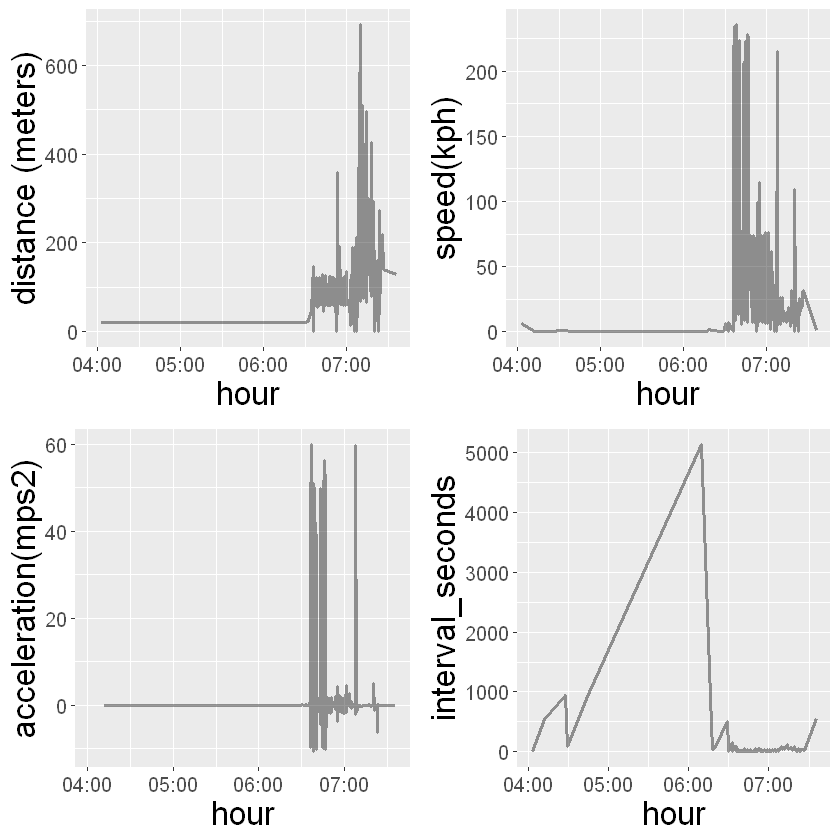

In [36]:
grid.arrange(p1, p2, p3, p4, ncol=2, nrow=2)

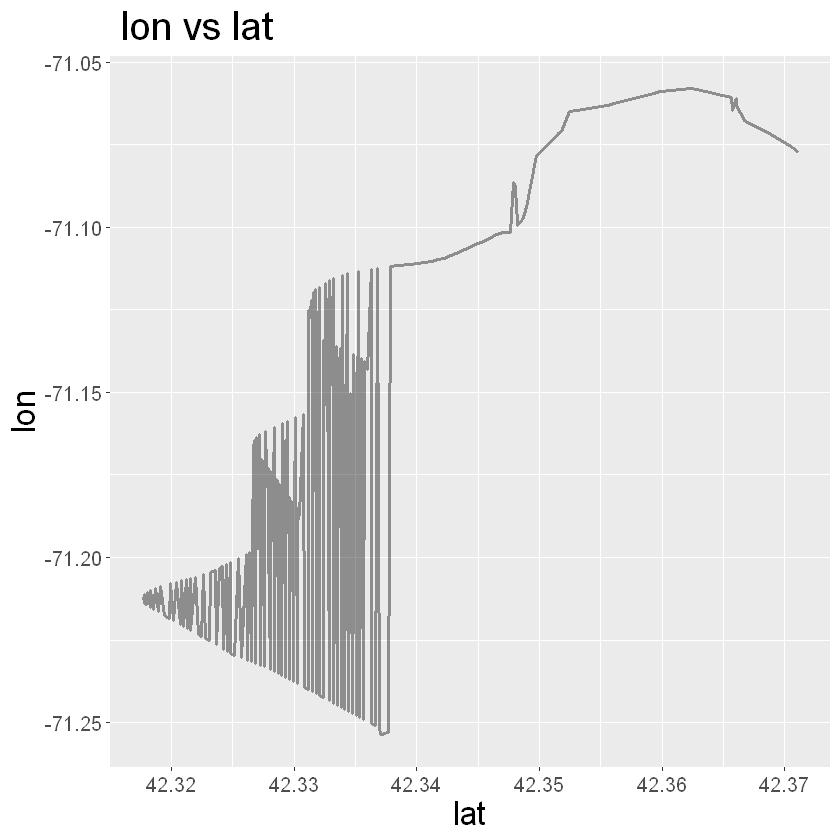

In [63]:
ggplot(df_1_10001_calculate) + 
 geom_line(aes(x=lat, y=lon),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(title =" lon vs lat ", y = "lon", x = "lat")

## Vehicle distance,speed, acceleration calculation 
### Spurious values statistics
### Value correction

In [18]:
# Function to compute distances (D), speeds (S) and acceleration (A) in meters, meters per second, km per hour and m s^-2
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
#     d$dist_meters = NA
#     d$dist_meters = as.numeric(d$dist_meters)
#     d$interval_seconds = NA
#     d$interval_seconds = as.numeric(d$interval_seconds)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    diagnostics = {}
    if (n >= 2) {
#         # Compute interval distance using Haversine function
#         d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
#         # Compute time interval
#         d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        # Compute speed in meters per second
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        # # Compute accelerations
        # d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Spurious values statistics
        index_excessive_speeds = as.numeric(row.names(d[(d$speed_kph > 128) & (!is.na(d$speed_kph)),]))
        # Original data metrics calculation
         diagnostics$mean_original_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_original_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_original_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_original_speed_kph = length(as.numeric(d[, "speed_kph"]))
        # Excessive data metrics calculation
         diagnostics$mean_excess_speed_kph = mean(as.numeric(d[index_excessive_speeds, "speed_kph"]))
         diagnostics$min_excess_speed_kph = min(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$max_excess_speed_kph = max(as.numeric(d[index_excessive_speeds, "speed_kph"])) 
         diagnostics$num_excess_speed_kph = length(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$prop_excess_speed_kph = round(100*diagnostics$num_excess_speed/n, 2)
        # Correct the excessive speed values and recalculate acceleration and distance
        repeat{
        d[index_excessive_speeds, c('speed_kph',"speed_mps")] = d[index_excessive_speeds - 1 , c('speed_kph',"speed_mps")]
        d[index_excessive_speeds, "dist_meters"] = d[index_excessive_speeds, "speed_mps"] * d[index_excessive_speeds,"interval_seconds"]
        # d[index_excessive_speeds, "accel_mps2"] = (d[index_excessive_speeds, "speed_mps"] 
        #                                           - d[index_excessive_speeds - 1, "speed_mps"]) / d[index_excessive_speeds,"interval_seconds"]
        if(max(d$speed_kph,na.rm = TRUE) <= 128){break}
        }
         # Compute accelerations
         d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Correct accelerations
         index_excessive_accelerations = as.numeric(row.names(d[(d$dist_meters == 0) & (d$accel_mps2 > 6),]))
         d[index_excessive_accelerations, "accel_mps2"] = d[index_excessive_accelerations - 1 , "accel_mps2"]
        # Corrected data metrics calculation
         diagnostics$mean_corrected_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_corrected_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_corrected_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_corrected_speed_kph = length(as.numeric(d[, "speed_kph"]))
    }
    return(list(data = d ,diag_metrics = diagnostics))   
}

In [21]:
# Process calculation 
process_month_trajectory = function(data){
    results_df = data.frame() # empty dataframe
    diagnostics_df = data.frame()
    for(i in unique(data$day)) { 
        data_day <- data[data$day == i, ]
        # Put each train in one loop in a subset
        for (j in unique(data_day$trainid)) {
            data_day_train = data_day[data_day$trainid == j, ]        
            trajectory_and_diagnostics <- compute_trajectories(data_day_train)  
            trajectories = trajectory_and_diagnostics$data
            diagnostics = trajectory_and_diagnostics$diag_metrics          
            results_df <- rbind(results_df, trajectories)
            diagnostics_df <- rbind(diagnostics_df, diagnostics) 
        }
    }
     write.csv(x = results_df, file.path("../../data/tidy/", paste("trajectory", yy, mm, ".csv", sep = "-", collapse = "")))
    write.csv(x = diagnostics_df, file.path("../../data/tidy/", paste("trajectory-diagnostics" , yy, mm, ".csv", sep = "-",collapse = "")))
    # Uncomment the beneath line and check the computation result
    # return(list(result = results_df, result_diag = diagnostics_df ))
 }

In [ ]:
# Generate the final table
main = function(YEARLIST, MONTHLIST) {
    for (y in YEARLIST) {
        for (m in MONTHLIST) {
            df_agg = aggregate_line_trajectories(y, m)
            df_agg = preprocess_data(df_agg)
            process_month_trajectory(df_agg, y, m)            
        }
    }
}

In [ ]:
main(YEARLIST, MONTHLIST)

## something which will be used or not (this part wiil be deleted when this script has been done)

In [ ]:
# # aggregrate_trajectory_table
# aggregate_line_trajectories = function(year, month){
#     assign("dg", fread(paste(DISTANCE_FILEPATH, paste(paste(c("lightrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
#     assign("dh", fread(paste(DISTANCE_FILEPATH, paste(paste(c("heavyrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
#     # Combine the original tables to a single one for analysis
#     dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
#     dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
#     df = rbind(dg, dh)
#     return(df)
# }

In [ ]:
# aggregrate_trajectory_table
aggregate_line_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    # Combine the original tables to a single one for analysis
    dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
    dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
    df = rbind(dg, dh)
    return(df)
}

In [ ]:
# Fixed file path
assign("df", fread(paste(DISTANCE_FILEPATH, paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))

In [ ]:
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
get_heavy_rail_trajectories = function(year, month){
    assign("df", fread(paste(DISTANCE_FILEPATH, paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    df = add_dd_mm_yy_cols(df)
    return(df)
}

get_light_rail_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dg = add_dd_mm_yy_cols(dg)
    return(dg)
}